In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

In [2]:
stores = pd.read_csv('new_data/stores.csv')
promotions = pd.read_csv('new_data/promotions.csv', parse_dates=['Date'])
df = pd.read_csv('new_data/dataset.csv', parse_dates=['Date'], low_memory=False)

# Sort df by Date
df = df.sort_values(by='Date')

In [3]:
# Removing all closed stores
df = df[df['Open'] == 1]

In [4]:
df.drop(columns=['Open'], inplace=True)
display(df)

,Store,Date,Sales,Customers
1016447,353,2013-01-01,3139,820
1016429,335,2013-01-01,2401,482
1016606,512,2013-01-01,2646,625
1016588,494,2013-01-01,3113,527
1016624,530,2013-01-01,2907,532
...,...,...,...,...
745,746,2015-07-31,9082,638
746,747,2015-07-31,10708,826
747,748,2015-07-31,7481,578
741,742,2015-07-31,10460,1016


In [5]:
def get_promo_dates(stores_df: pd.DataFrame) -> pd.DataFrame:
    stores_df = stores_df.copy()
    stores_df = stores_df.dropna(subset=['PromoInterval', 'PromoSinceYear', 'PromoSinceWeek'])

    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    promo_rows = []
    for _, row in stores_df.iterrows():
        store_id = row['Store']
        promo_year = int(row['PromoSinceYear'])
        promo_week = int(row['PromoSinceWeek'])
        months = [m.strip() for m in row['PromoInterval'].split(',')]

        promo_start_date = pd.to_datetime(f'{promo_year}-W{int(promo_week):02d}-1', format='%Y-W%W-%w')

        for year in range(promo_year, 2016):
            for month in months:
                month_num = month_map[month]
                promo_date = pd.Timestamp(year=year, month=month_num, day=1)

                if promo_date >= promo_start_date:
                    month_dates = pd.date_range(start=promo_date, end=promo_date + pd.offsets.MonthEnd(0), freq='D')
                    for d in month_dates:
                        promo_rows.append({'Store': store_id, 'Date': pd.to_datetime(d)})

    promo_df = pd.DataFrame(promo_rows)
    return promo_df

promo_dates_df = get_promo_dates(stores)
display(promo_dates_df)
# promo_dates_df.to_csv('new_data/promo_dates.csv', index=False)

,Store,Date
0,2,2010-04-01
1,2,2010-04-02
2,2,2010-04-03
3,2,2010-04-04
4,2,2010-04-05
...,...,...
256755,1115,2015-12-27
256756,1115,2015-12-28
256757,1115,2015-12-29
256758,1115,2015-12-30


In [6]:
# Add promo_dates_df to promotions
promotions = pd.merge(promotions, promo_dates_df, on=['Store', 'Date'], how='outer')
promotions = promotions.drop_duplicates(subset=['Store', 'Date'])
promotions = promotions.sort_values(by=['Store', 'Date'])
display(promotions)

,Store,Date
0,1,2013-01-07
1,1,2013-01-08
2,1,2013-01-09
3,1,2013-01-10
4,1,2013-01-11
...,...,...
577877,1115,2015-12-27
577878,1115,2015-12-28
577879,1115,2015-12-29
577880,1115,2015-12-30


In [7]:
# Merge stores with df
df = pd.merge(df, stores, on='Store', how='left')
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance,PromoSinceWeek,PromoSinceYear,PromoInterval
0,353,2013-01-01,3139,820,Medium,900.0,14.0,2013.0,"Feb,May,Aug,Nov"
1,335,2013-01-01,2401,482,Small,90.0,31.0,2013.0,"Jan,Apr,Jul,Oct"
2,512,2013-01-01,2646,625,Medium,590.0,5.0,2013.0,"Mar,Jun,Sept,Dec"
3,494,2013-01-01,3113,527,Small,1260.0,NaN,NaN,NaN
4,530,2013-01-01,2907,532,Large,18160.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
844387,746,2015-07-31,9082,638,Large,4330.0,35.0,2011.0,"Mar,Jun,Sept,Dec"
844388,747,2015-07-31,10708,826,Large,45740.0,NaN,NaN,NaN
844389,748,2015-07-31,7481,578,Small,2380.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
844390,742,2015-07-31,10460,1016,Large,4380.0,NaN,NaN,NaN


In [8]:
df.drop(columns=['PromoSinceWeek', 'PromoSinceYear', 'PromoInterval'], inplace=True)
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance
0,353,2013-01-01,3139,820,Medium,900.0
1,335,2013-01-01,2401,482,Small,90.0
2,512,2013-01-01,2646,625,Medium,590.0
3,494,2013-01-01,3113,527,Small,1260.0
4,530,2013-01-01,2907,532,Large,18160.0
...,...,...,...,...,...,...
844387,746,2015-07-31,9082,638,Large,4330.0
844388,747,2015-07-31,10708,826,Large,45740.0
844389,748,2015-07-31,7481,578,Small,2380.0
844390,742,2015-07-31,10460,1016,Large,4380.0


In [9]:
# Merge df with promotions on 'Store' and 'Date', keeping only rows present in df
df = pd.merge(df, promotions, on=['Store', 'Date'], how='left', indicator='promo_merge')
df['Promo'] = (df['promo_merge'] == 'both').astype(int)
df.drop(columns=['promo_merge'], inplace=True)
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance,Promo
0,353,2013-01-01,3139,820,Medium,900.0,0
1,335,2013-01-01,2401,482,Small,90.0,0
2,512,2013-01-01,2646,625,Medium,590.0,0
3,494,2013-01-01,3113,527,Small,1260.0,0
4,530,2013-01-01,2907,532,Large,18160.0,0
...,...,...,...,...,...,...,...
844387,746,2015-07-31,9082,638,Large,4330.0,1
844388,747,2015-07-31,10708,826,Large,45740.0,1
844389,748,2015-07-31,7481,578,Small,2380.0,1
844390,742,2015-07-31,10460,1016,Large,4380.0,1


In [10]:
# Add day of week as a integer
df['DayOfWeek'] = df['Date'].dt.dayofweek
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance,Promo,DayOfWeek
0,353,2013-01-01,3139,820,Medium,900.0,0,1
1,335,2013-01-01,2401,482,Small,90.0,0,1
2,512,2013-01-01,2646,625,Medium,590.0,0,1
3,494,2013-01-01,3113,527,Small,1260.0,0,1
4,530,2013-01-01,2907,532,Large,18160.0,0,1
...,...,...,...,...,...,...,...,...
844387,746,2015-07-31,9082,638,Large,4330.0,1,4
844388,747,2015-07-31,10708,826,Large,45740.0,1,4
844389,748,2015-07-31,7481,578,Small,2380.0,1,4
844390,742,2015-07-31,10460,1016,Large,4380.0,1,4


In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['Assortment'] = encoder.fit_transform(df['Assortment'])

In [12]:
display(df.head())

,Store,Date,Sales,Customers,Assortment,CompetitionDistance,Promo,DayOfWeek
0,353,2013-01-01,3139,820,1,900.0,0,1
1,335,2013-01-01,2401,482,2,90.0,0,1
2,512,2013-01-01,2646,625,1,590.0,0,1
3,494,2013-01-01,3113,527,2,1260.0,0,1
4,530,2013-01-01,2907,532,0,18160.0,0,1


In [13]:
print(encoder.inverse_transform([0, 1, 2]))

['Large' 'Medium' 'Small']


In [14]:
df.drop(columns=['Customers'], inplace=True)

In [15]:
test = pd.read_csv('new_data/test.csv', parse_dates=['Date'], low_memory=False)
display(test)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [16]:
test.drop(columns=['StateHoliday', 'SchoolHoliday'], inplace=True)
display(test)

,Id,Store,DayOfWeek,Date,Open,Promo
0,1,1,4,2015-09-17,1.0,1
1,2,3,4,2015-09-17,1.0,1
2,3,7,4,2015-09-17,1.0,1
3,4,8,4,2015-09-17,1.0,1
4,5,9,4,2015-09-17,1.0,1
...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0
41084,41085,1112,6,2015-08-01,1.0,0
41085,41086,1113,6,2015-08-01,1.0,0
41086,41087,1114,6,2015-08-01,1.0,0


In [17]:
# Add Assortment and CompetitionDistance to test
test = pd.merge(test, stores, on='Store', how='left')
display(test)

,Id,Store,DayOfWeek,Date,Open,Promo,Assortment,CompetitionDistance,PromoSinceWeek,PromoSinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,Small,1270.0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,Small,14130.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,Large,24000.0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,Small,7520.0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,Large,2030.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,Small,1900.0,31.0,2013.0,"Jan,Apr,Jul,Oct"
41084,41085,1112,6,2015-08-01,1.0,0,Large,1880.0,NaN,NaN,NaN
41085,41086,1113,6,2015-08-01,1.0,0,Large,9260.0,NaN,NaN,NaN
41086,41087,1114,6,2015-08-01,1.0,0,Large,870.0,NaN,NaN,NaN


In [18]:
test.drop(columns=['PromoSinceWeek', 'PromoSinceYear', 'PromoInterval'], inplace=True)
display(test)

,Id,Store,DayOfWeek,Date,Open,Promo,Assortment,CompetitionDistance
0,1,1,4,2015-09-17,1.0,1,Small,1270.0
1,2,3,4,2015-09-17,1.0,1,Small,14130.0
2,3,7,4,2015-09-17,1.0,1,Large,24000.0
3,4,8,4,2015-09-17,1.0,1,Small,7520.0
4,5,9,4,2015-09-17,1.0,1,Large,2030.0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,Small,1900.0
41084,41085,1112,6,2015-08-01,1.0,0,Large,1880.0
41085,41086,1113,6,2015-08-01,1.0,0,Large,9260.0
41086,41087,1114,6,2015-08-01,1.0,0,Large,870.0


In [19]:
encoder = LabelEncoder()
test['Assortment'] = encoder.fit_transform(test['Assortment'])
display(test.head())

,Id,Store,DayOfWeek,Date,Open,Promo,Assortment,CompetitionDistance
0,1,1,4,2015-09-17,1.0,1,2,1270.0
1,2,3,4,2015-09-17,1.0,1,2,14130.0
2,3,7,4,2015-09-17,1.0,1,0,24000.0
3,4,8,4,2015-09-17,1.0,1,2,7520.0
4,5,9,4,2015-09-17,1.0,1,0,2030.0


In [20]:
open_indices = test['Open'] == 1
print(open_indices)

0        True
1        True
2        True
3        True
4        True
         ... 
41083    True
41084    True
41085    True
41086    True
41087    True
Name: Open, Length: 41088, dtype: bool


In [21]:
test.drop(columns=['Open'], inplace=True)
display(test)

,Id,Store,DayOfWeek,Date,Promo,Assortment,CompetitionDistance
0,1,1,4,2015-09-17,1,2,1270.0
1,2,3,4,2015-09-17,1,2,14130.0
2,3,7,4,2015-09-17,1,0,24000.0
3,4,8,4,2015-09-17,1,2,7520.0
4,5,9,4,2015-09-17,1,0,2030.0
...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,0,2,1900.0
41084,41085,1112,6,2015-08-01,0,0,1880.0
41085,41086,1113,6,2015-08-01,0,0,9260.0
41086,41087,1114,6,2015-08-01,0,0,870.0


In [23]:
def split_dataset(train, test):
    train = train.copy()
    test = test.copy()

    train = train.drop(columns=['Date'])
    test = test.drop(columns=['Id', 'Date'])

    X_train, y_train = train.drop(columns='Sales'), train['Sales']
    X_test, y_test = test, None

    return X_train, y_train, X_test, y_test

df = df.sort_values(by='Date')
test = test.sort_values(by='Date')

df = df.reindex(columns=['Store', 'DayOfWeek', 'Date', 'Sales', 'Promo', 'Assortment', 'CompetitionDistance'])
test = test.reindex(columns=['Id','Store', 'DayOfWeek', 'Date', 'Promo', 'Assortment', 'CompetitionDistance'])

X_train, y_train, X_test, y_test = split_dataset(df, test)

In [24]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

In [25]:
import json

try:
    with open('best_params.json', 'r') as f:
        best_params = json.load(f)
except FileNotFoundError:
    best_params = None    

if not best_params:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
print(f"Best parameters: {best_params}")

Best parameters: {'n_estimators': 475, 'max_depth': 9, 'learning_rate': 0.22594731375525895, 'subsample': 0.9841937224705313, 'colsample_bytree': 0.8115993503676006, 'min_child_weight': 9, 'gamma': 1.0508620811373048, 'reg_alpha': 0.2682513430967105, 'reg_lambda': 1.962135997883376, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}


In [27]:
best_params['tree_method'] = 'hist'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

model = XGBRegressor(**best_params)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)

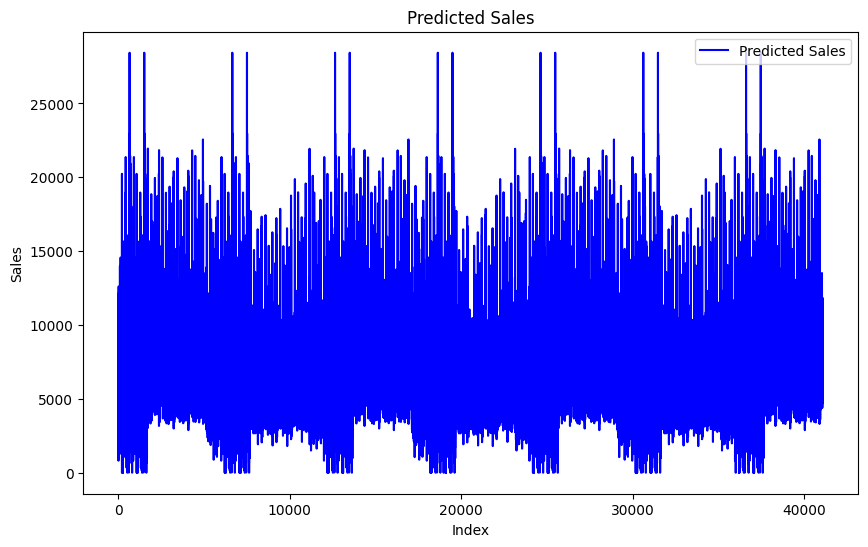

In [30]:
# plot y_pred

plt.figure(figsize=(10, 6))
plt.plot(y_pred, label='Predicted Sales', color='blue')
plt.title('Predicted Sales')
plt.xlabel('Index')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [28]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Mean Sales: {y_test.mean():.2f}")
print(f"Error percentage: {rmse / y_test.mean() * 100:.2f}%")

InvalidParameterError: The 'y_true' parameter of root_mean_squared_error must be an array-like. Got None instead.

In [29]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(14,6))
    plt.plot(y_test.values, label='Actual Sales')
    plt.plot(y_pred, label='Predicted Sales')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Sample Index (time ordered)')
    plt.ylabel('Sales')
    plt.legend()
    plt.savefig('actual_vs_predicted.png')
    plt.show()

n = 50

plot_actual_vs_predicted(y_test[:n], y_pred[:n])

TypeError: 'NoneType' object is not subscriptable

In [ ]:
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)